In this notebook, I compare three standard approaches to the Multi-Armed Bandit problem - **Epsilon-Greedy**, **Upper Confidence Bound**, and **Thompson Sampling**. The implementations of these algorithms are based on examples from [GeeksforGeeks](https://www.geeksforgeeks.org/machine-learning/multi-armed-bandit-problem-in-reinforcement-learning/).

# Aproaches

## Epsilon-Greedy

In [1]:
class EpsilonGreedy:
    def __init__(self, n_arms, epsilon):
        self.n_arms = n_arms
        self.epsilon = epsilon
        self.counts = np.zeros(n_arms)  # Number of times each arm is pulled
        self.values = np.zeros(n_arms)  # Estimated values of each arm

    def select_arm(self):
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, self.n_arms)
        else:
            return np.argmax(self.values)

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] += 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        self.values[chosen_arm] = ((n - 1) / n) * value + (1 / n) * reward

## Upper Confidence Bound

In [2]:
class UCB:
    def __init__(self, n_arms):
        self.n_arms = n_arms
        self.counts = np.zeros(n_arms)
        self.values = np.zeros(n_arms)
        self.total_counts = 0

    def select_arm(self):
        ucb_values = self.values + np.sqrt(2 * np.log(self.total_counts + 1) / (self.counts + 1e-5))
        return np.argmax(ucb_values)

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] += 1
        self.total_counts += 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        self.values[chosen_arm] = ((n - 1) / n) * value + (1 / n) * reward

## Thompson Sampling

In [3]:
class ThompsonSampling:
    def __init__(self, n_arms):
        self.n_arms = n_arms
        self.successes = np.zeros(n_arms)
        self.failures = np.zeros(n_arms)

    def select_arm(self):
        sampled_values = np.random.beta(self.successes + 1, self.failures + 1)
        return np.argmax(sampled_values)

    def update(self, chosen_arm, reward):
        if reward > 0:
            self.successes[chosen_arm] += 1
        else:
            self.failures[chosen_arm] += 1

# Simulation

The goal of this simulation is to compare the basic properties of these three approaches.

In [4]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Deterministic rewards

In [5]:
# Function for simulation
def simulate_deterministic(agent_class, agent_kwargs, true_rewards, n_steps, n_simulations):
    n_arms = len(true_rewards)
    rng_sim = np.random.default_rng()
    total_rewards = np.zeros((n_simulations, n_steps))
    records = []

    algorithm_label = f"{agent_class.__name__} {agent_kwargs}"
    for sim in range(n_simulations):
        agent = agent_class(**agent_kwargs)
        reward_cum = 0 
        
        for t in range(n_steps): 
            # Agent
            arm = agent.select_arm()
            reward = true_rewards[arm] # no noise, same reward all the time
            agent.update(arm, reward)
            
            # Save rewards
            reward_cum += reward
            total_rewards[sim, t] = reward
            
            # Save record
            records.append({
                "Simulation": sim,
                "Step": t,
                "Algorithm": algorithm_label,
                **agent_kwargs,
                "Reward": reward,
                "Cumulative Reward": reward_cum
            })

    # Calculate some statistics
    cumulative_rewards = np.cumsum(total_rewards, axis=1) # Kumulativní odměny v čase pro každou simulaci
    mean_rewards = np.mean(cumulative_rewards, axis=0) # Průměrný průběh kumulativní odměny napříč simulacemi
    std_rewards = np.std(cumulative_rewards[:, -1]) # Směrodatná odchylka celkové odměny na konci (stabilita výkonu)
    final_mean = np.mean(cumulative_rewards[:, -1]) # Průměrná celková odměna na konci simulací (výkon algoritmu)
        
    return {
    "mean_rewards": mean_rewards,
    "std_rewards": std_rewards,
    "final_mean": final_mean,
    "records_df": pd.DataFrame(records)
}

In [6]:
# Parameters
n_arms = 10
true_rewards = np.array([0.2, 0.5, 0.8, 0.1, 0.3, 0.4, 0.7, 0.6, 0.25, 0.05])
n_steps = 1000
n_simulations = 1000

In [7]:
# Run the simulation
results1 = {}

In [8]:
results1["Epsilon-Greedy (ε=0.1)"] = simulate_deterministic(
    EpsilonGreedy, {"n_arms": n_arms, 
                    "epsilon": 0.1}, 
    true_rewards, 
    n_steps,
    n_simulations
)

In [9]:
results1["UCB"] = simulate_deterministic(
    UCB, {"n_arms": 
          n_arms}, 
    true_rewards, 
    n_steps,
    n_simulations
)

In [10]:
binary_rewards = (true_rewards > 0.5).astype(int)
results1["Thompson Sampling"] = simulate_deterministic(
    ThompsonSampling, {"n_arms": n_arms},
    binary_rewards, 
    n_steps,
    n_simulations
)

In [11]:
# Check the results
df_all1 = pd.concat([result["records_df"] for result in results1.values()], ignore_index=True)
# df_all.head()
df_all1

,Simulation,Step,Algorithm,n_arms,epsilon,Reward,Cumulative Reward
0,0,0,"EpsilonGreedy {'n_arms': 10, 'epsilon': 0.1}",10,0.1,0.2,0.2
1,0,1,"EpsilonGreedy {'n_arms': 10, 'epsilon': 0.1}",10,0.1,0.2,0.4
2,0,2,"EpsilonGreedy {'n_arms': 10, 'epsilon': 0.1}",10,0.1,0.8,1.2
3,0,3,"EpsilonGreedy {'n_arms': 10, 'epsilon': 0.1}",10,0.1,0.8,2.0
4,0,4,"EpsilonGreedy {'n_arms': 10, 'epsilon': 0.1}",10,0.1,0.8,2.8
...,...,...,...,...,...,...,...
2999995,999,995,ThompsonSampling {'n_arms': 10},10,NaN,1.0,986.0
2999996,999,996,ThompsonSampling {'n_arms': 10},10,NaN,1.0,987.0
2999997,999,997,ThompsonSampling {'n_arms': 10},10,NaN,1.0,988.0
2999998,999,998,ThompsonSampling {'n_arms': 10},10,NaN,1.0,989.0


In [12]:
# Print the mean and std for the aproaches
for name, result in results1.items():
    print(f"{name}: Final mean = {result['final_mean']:.2f}, Std = {result['std_rewards']:.2f}")

Epsilon-Greedy (ε=0.1): Final mean = 737.48, Std = 17.58
UCB: Final mean = 653.60, Std = 0.00
Thompson Sampling: Final mean = 991.46, Std = 1.28


In [13]:
def plot_mean_cumulative_reward_with_ci(results, n_steps=1000, ylim_max=800):
    """
    Vykreslí průměrnou kumulativní odměnu s intervalem spolehlivosti (± std).
    
    Parametry:
    ----------
    results : dict
        Slovník s názvy algoritmů jako klíče a strukturou:
        {
            "mean_rewards": np.array,
            "std_rewards": np.array,
            ...
        }

    n_steps : int
        Počet kroků (x-osa).

    ylim_max : int
        Maximální hodnota osy Y.
    """
    plt.figure(figsize=(12, 6))

    for label, result in results.items():
        mean_rewards = result["mean_rewards"]
        std_rewards = result["std_rewards"]
        
        plt.plot(mean_rewards, label=label)
        plt.fill_between(range(n_steps),
                         mean_rewards - std_rewards,
                         mean_rewards + std_rewards,
                         alpha=0.2)

    plt.xlabel("Steps")
    plt.ylabel("Mean Cumulative Reward")
    plt.title("Mean Cumulative reward with confidence interval")
    plt.legend()
    plt.xlim(0, n_steps)
    plt.ylim(0, ylim_max)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [14]:
def plot_first_n_simulations(df_all, n_simulations=20, xlim_max=1000, ylim_max=800):
    """
    Vykreslí kumulativní odměny pro prvních N simulací podle algoritmu.
    
    Parametry:
    ----------
    df_all : pandas.DataFrame
        DataFrame obsahující sloupce "Step", "Cumulative Reward", "Simulation" a "Algorithm".
    
    n_simulations : int
        Počet simulací, které se mají vykreslit.
    
    xlim_max : int
        Maximální hodnota osy X (počet kroků).
    
    ylim_max : int
        Maximální hodnota osy Y (kumulativní odměna).
    """

    df_plot = df_all[df_all["Simulation"] < n_simulations]

    plt.figure(figsize=(14, 6))
    sns.lineplot(
        data=df_plot,
        x="Step",
        y="Cumulative Reward",
        hue="Algorithm",
        units="Simulation",      
        estimator=None,           
        lw=1   
    )
    plt.title(f"Cumulative reward for first {n_simulations} simulations")
    plt.xlim(0, xlim_max)
    plt.ylim(0, ylim_max)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [15]:
def plot_all_simulations(df_all, xlim_max=1000, ylim_max=800):
    """
    Vykreslí kumulativní odměny všech simulací podle algoritmu.
    
    Parametry:
    ----------
    df_all : pandas.DataFrame
        DataFrame obsahující sloupce "Step", "Cumulative Reward", "Simulation" a "Algorithm".
    
    xlim_max : int
        Maximální hodnota osy X (počet kroků).
    
    ylim_max : int
        Maximální hodnota osy Y (kumulativní odměna).
    """
    
    plt.figure(figsize=(14, 6))

    sns.lineplot(
        data=df_all,
        x="Step",
        y="Cumulative Reward",
        hue="Algorithm",
        units="Simulation",      
        estimator=None,           
        lw=1
    )

    plt.title("Cumulative reward across all simulations")
    plt.xlim(0, xlim_max)
    plt.ylim(0, ylim_max)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

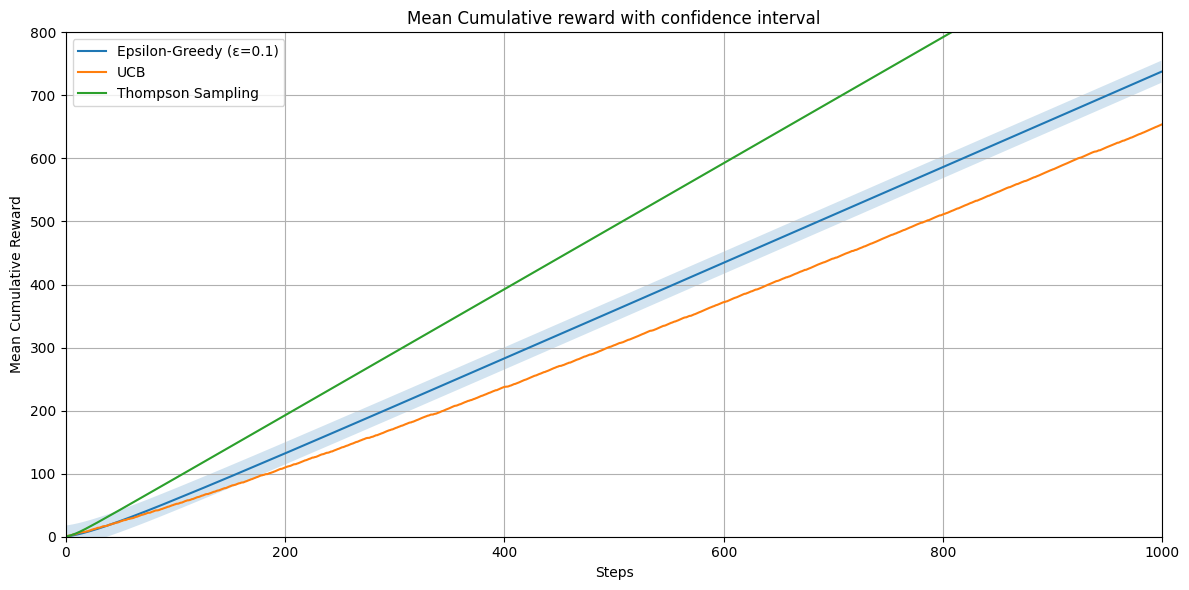

In [16]:
plot_mean_cumulative_reward_with_ci(results1, n_steps=1000, ylim_max=800)

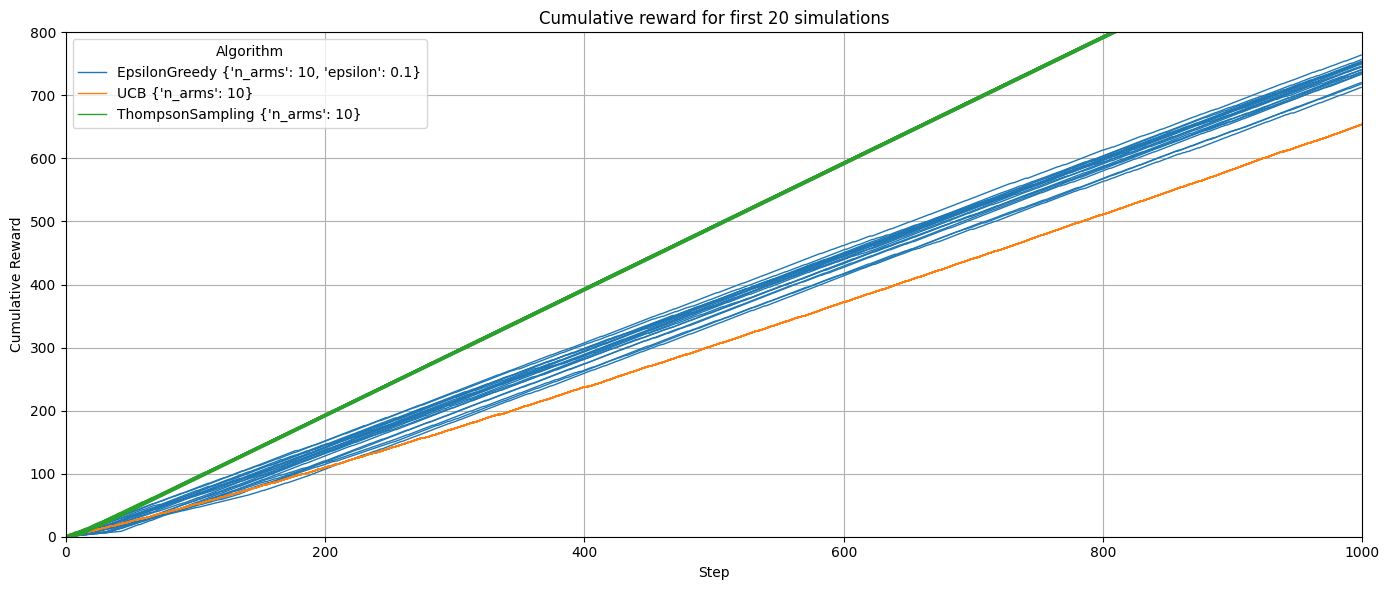

In [17]:
plot_first_n_simulations(df_all1, n_simulations=20, xlim_max=1000, ylim_max=800)

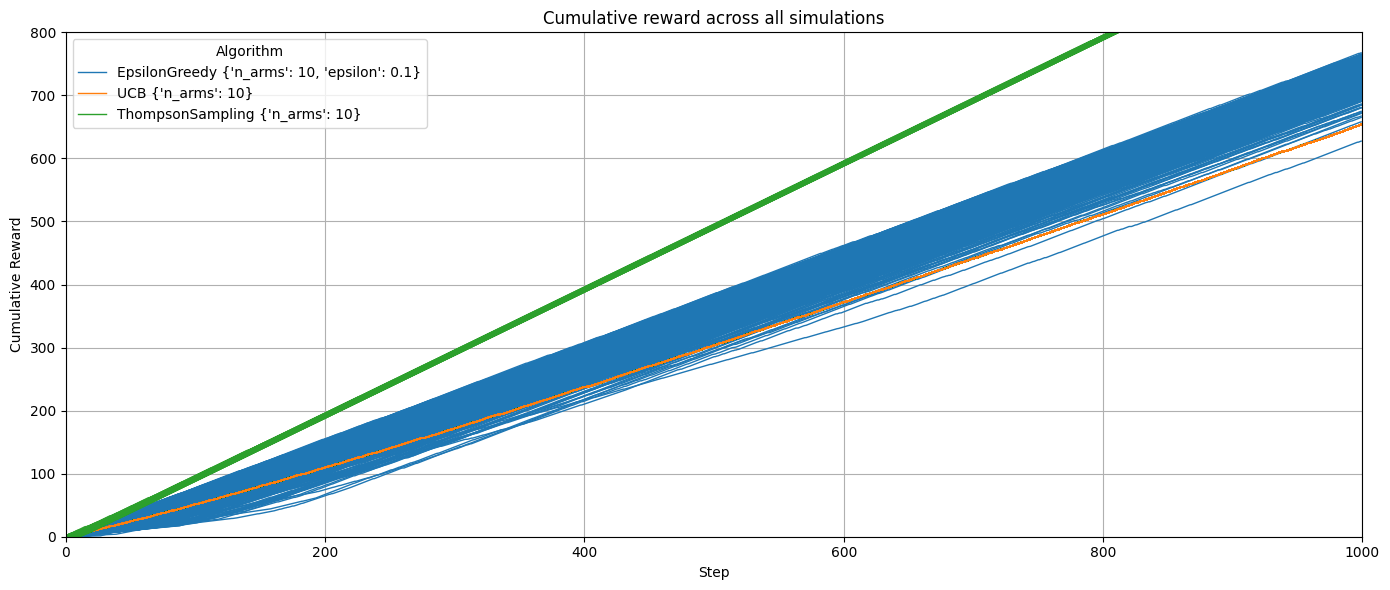

In [18]:
plot_all_simulations(df_all1, xlim_max=1000, ylim_max=800)

## Deterministic rewards (MABWiser)

In [19]:
# Libraries
from mabwiser.mab import MAB, LearningPolicy

In [20]:
def simulate_deterministic_mabwiser(true_rewards, n_steps, n_simulations, learning_policy, policy_name):
    n_arms = len(true_rewards)
    results_records = []

    algorithm_label = f"Epsilon-Greedy (ε={epsilon})"

    for sim in range(n_simulations):
        mab = MAB(
            arms=list(range(n_arms)),
            learning_policy=LearningPolicy.EpsilonGreedy(epsilon=epsilon),
            seed=sim
        )
        mab.fit(decisions=[], rewards=[])

        reward_cum = 0
        for t in range(n_steps):
            arm = mab.predict()
            reward = true_rewards[arm]
            mab.partial_fit(decisions=[arm], rewards=[reward])
            reward_cum += reward
            total_rewards[sim, t] = reward

            records.append({
                "Simulation": sim,
                "Step": t,
                "Algorithm": algorithm_label,
                "n_arms": n_arms,
                "epsilon": epsilon,
                "Reward": reward,
                "Cumulative Reward": reward_cum
            })

    cumulative_rewards = np.cumsum(total_rewards, axis=1)
    mean_rewards = np.mean(cumulative_rewards, axis=0)
    std_rewards = np.std(cumulative_rewards[:, -1])
    final_mean = np.mean(cumulative_rewards[:, -1])

    return {
        "mean_rewards": mean_rewards,
        "std_rewards": std_rewards,
        "final_mean": final_mean,
        "records_df": pd.DataFrame(records)
    }

In [21]:
def simulate_deterministic_mabwiser(true_rewards, n_steps, n_simulations, learning_policy, policy_name):
    n_arms = len(true_rewards)
    results_records = []

    for sim in range(n_simulations):
        mab = MAB(
            arms=list(range(n_arms)),
            learning_policy=learning_policy,
            seed=sim
        )
        mab.fit(decisions=[], rewards=[])
        cum_reward = 0

        for t in range(n_steps):
            arm = mab.predict()
            reward = true_rewards[arm]
            mab.partial_fit(decisions=[arm], rewards=[reward])
            cum_reward += reward

            results_records.append({
                "Simulation": sim,
                "Step": t,
                "Algorithm": policy_name,
                "Arm": arm,
                "Reward": reward,
                "Cumulative Reward": cum_reward
            })

    # Calculate some statistics
    df = pd.DataFrame(results_records)
    grouped = df.groupby(["Simulation", "Step"])["Reward"].sum().unstack(fill_value=0)
    cumulative_rewards = grouped.cumsum(axis=1).values
    mean_rewards = cumulative_rewards.mean(axis=0)
    std_rewards = cumulative_rewards[:, -1].std()
    final_mean = cumulative_rewards[:, -1].mean()

    return {
        "mean_rewards": mean_rewards,
        "std_rewards": std_rewards,
        "final_mean": final_mean,
        "records_df": df
    }

In [22]:
# Parameters
true_rewards = np.array([0.2, 0.5, 0.8, 0.1, 0.3, 0.4, 0.7, 0.6, 0.25, 0.05])
n_arms = len(true_rewards)
arms = list(range(n_arms))
n_steps = 1000
n_simulations = 1000

In [23]:
# Run the simulation
results2 = {}

In [24]:
results2["Epsilon-Greedy (ε=0.1)"] = simulate_deterministic_mabwiser(
    true_rewards=true_rewards,
    n_steps=n_steps,
    n_simulations=n_simulations,
    learning_policy=LearningPolicy.EpsilonGreedy(epsilon=0.1),
    policy_name="Epsilon-Greedy (ε=0.1)"
)

In [25]:
results2["UCB1"] = simulate_deterministic_mabwiser(
    true_rewards=true_rewards,
    n_steps=n_steps,
    n_simulations=n_simulations,
    learning_policy=LearningPolicy.UCB1(),
    policy_name="UCB1"
)

In [26]:
results2["ThompsonSampling"] = simulate_deterministic_mabwiser(
    true_rewards=true_rewards,
    n_steps=n_steps,
    n_simulations=n_simulations,
    learning_policy=LearningPolicy.ThompsonSampling(binarizer=lambda d, r: int(r > 0.5)),
    policy_name="ThompsonSampling"
)

In [27]:
# Check the results
df_all2 = pd.concat([result["records_df"] for result in results2.values()], ignore_index=True)
# df_all.head()
df_all2

,Simulation,Step,Algorithm,Arm,Reward,Cumulative Reward
0,0,0,Epsilon-Greedy (ε=0.1),0,0.2,0.20
1,0,1,Epsilon-Greedy (ε=0.1),0,0.2,0.40
2,0,2,Epsilon-Greedy (ε=0.1),6,0.7,1.10
3,0,3,Epsilon-Greedy (ε=0.1),2,0.8,1.90
4,0,4,Epsilon-Greedy (ε=0.1),2,0.8,2.70
...,...,...,...,...,...,...
2999995,999,995,ThompsonSampling,2,0.8,698.35
2999996,999,996,ThompsonSampling,7,0.6,698.95
2999997,999,997,ThompsonSampling,2,0.8,699.75
2999998,999,998,ThompsonSampling,2,0.8,700.55


In [28]:
# Print the mean and std for the aproaches
for name, result in results2.items():
    print(f"{name}: Final mean = {result['final_mean']:.2f}, Std = {result['std_rewards']:.2f}")

Epsilon-Greedy (ε=0.1): Final mean = 737.22, Std = 17.59
UCB1: Final mean = 200.00, Std = 0.00
ThompsonSampling: Final mean = 695.99, Std = 40.81


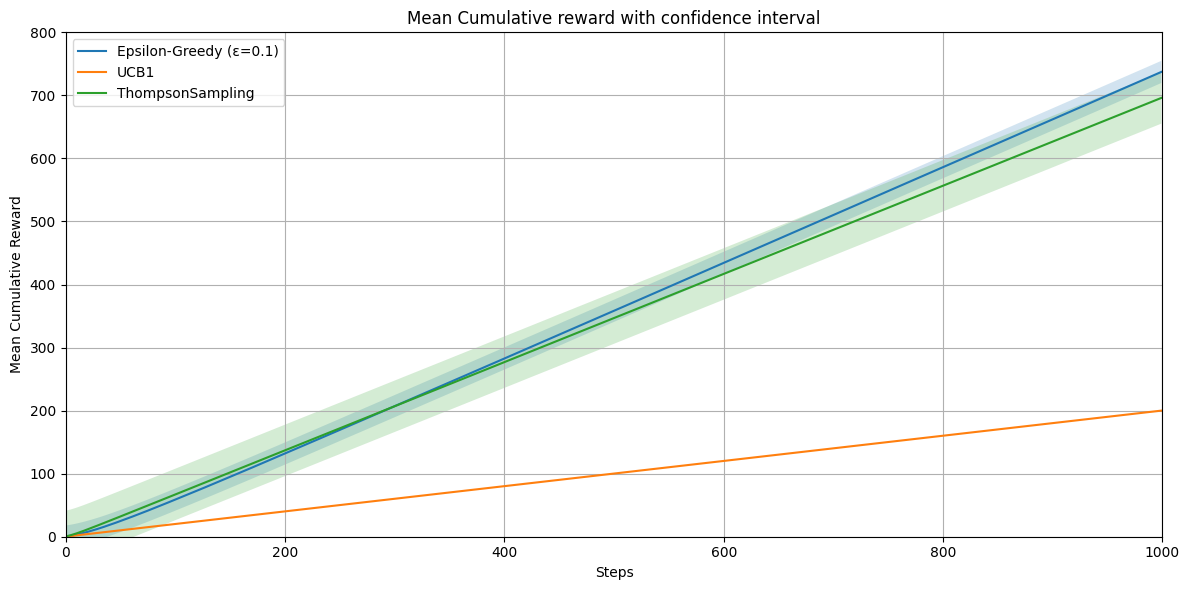

In [29]:
plot_mean_cumulative_reward_with_ci(results2, n_steps=1000, ylim_max=800)

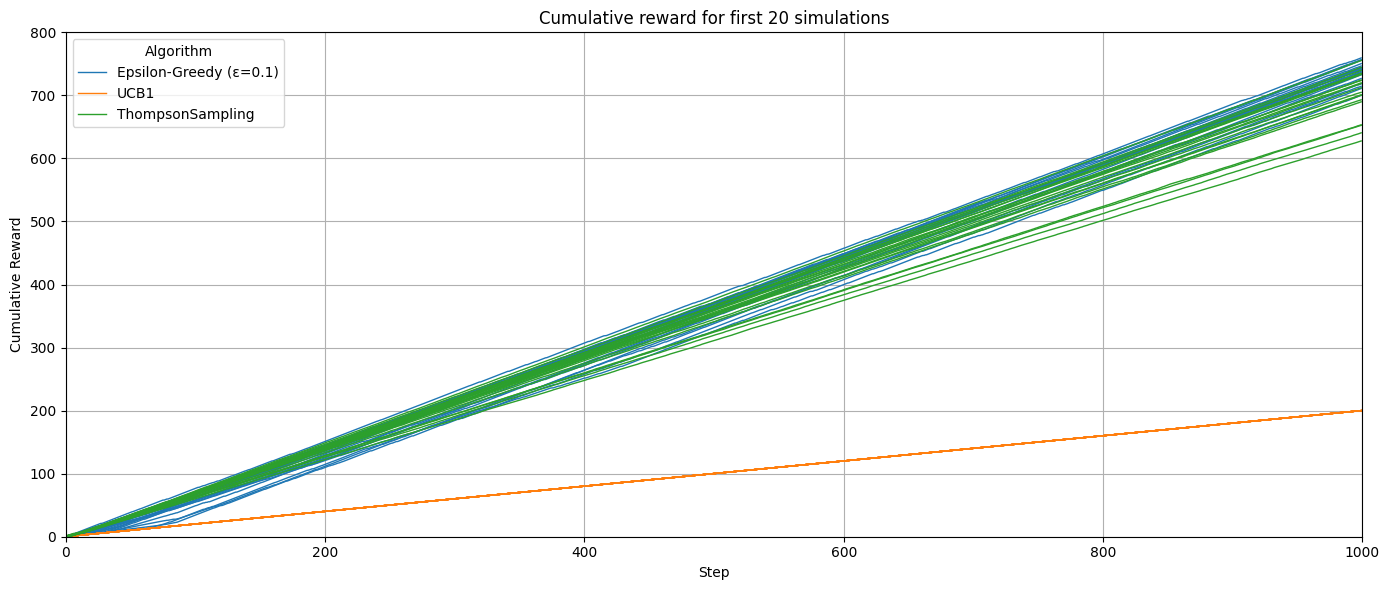

In [30]:
plot_first_n_simulations(df_all2, n_simulations=20, xlim_max=1000, ylim_max=800)

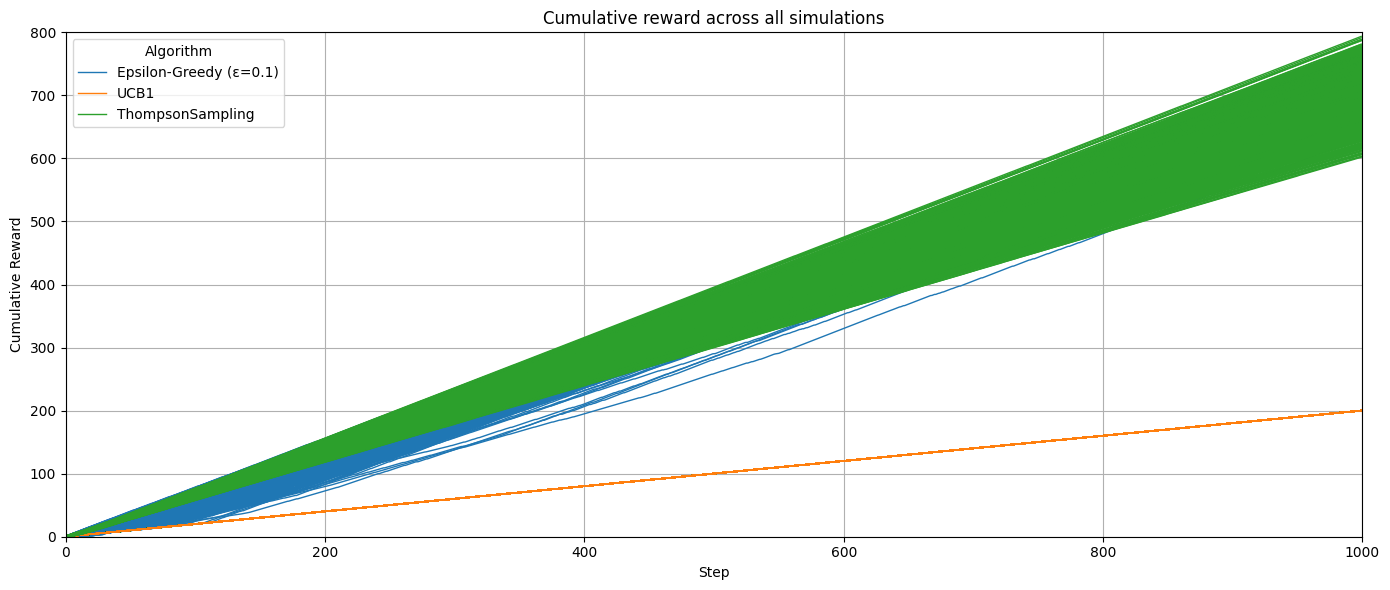

In [31]:
plot_all_simulations(df_all2, xlim_max=1000, ylim_max=800)

## Stochastic rewards

In [32]:
# Function for simulation
def simulate_stochastic(agent_class, agent_kwargs, true_rewards, n_steps, n_simulations):
    n_arms = len(true_rewards)
    rng_sim = np.random.default_rng()
    total_rewards = np.zeros((n_simulations, n_steps))
    records = []

    algorithm_label = f"{agent_class.__name__} {agent_kwargs}"
    for sim in range(n_simulations):
        agent = agent_class(**agent_kwargs)
        reward_cum = 0 
        
        for t in range(n_steps): 
            # Agent
            arm = agent.select_arm()
            reward = np.clip(rng_sim.normal(loc=true_rewards[arm], scale=0.1), 0, 1) # normal noise, different reward each time
            agent.update(arm, reward)
            
            # Save rewards
            reward_cum += reward
            total_rewards[sim, t] = reward
            
            # Save record
            records.append({
                "Simulation": sim,
                "Step": t,
                "Algorithm": algorithm_label,
                **agent_kwargs,
                "Reward": reward,
                "Cumulative Reward": reward_cum
            })

    # Calculate some statistics
    cumulative_rewards = np.cumsum(total_rewards, axis=1) # Kumulativní odměny v čase pro každou simulaci
    mean_rewards = np.mean(cumulative_rewards, axis=0) # Průměrný průběh kumulativní odměny napříč simulacemi
    std_rewards = np.std(cumulative_rewards[:, -1]) # Směrodatná odchylka celkové odměny na konci (stabilita výkonu)
    final_mean = np.mean(cumulative_rewards[:, -1]) # Průměrná celková odměna na konci simulací (výkon algoritmu)
        
    return {
    "mean_rewards": mean_rewards,
    "std_rewards": std_rewards,
    "final_mean": final_mean,
    "records_df": pd.DataFrame(records)
}

In [33]:
# Parameters
n_arms = 10
true_rewards = np.array([0.2, 0.5, 0.8, 0.1, 0.3, 0.4, 0.7, 0.6, 0.25, 0.05])
n_steps = 1000
n_simulations = 1000

In [35]:
# Run the simulation
results3 = {}

In [36]:
results3["Epsilon-Greedy (ε=0.1)"] = simulate_stochastic(
    EpsilonGreedy, {"n_arms": n_arms, 
                    "epsilon": 0.1}, 
    true_rewards, 
    n_steps,
    n_simulations
)

In [37]:
results3["UCB"] = simulate_stochastic(
    UCB, {"n_arms": 
          n_arms}, 
    true_rewards, 
    n_steps,
    n_simulations
)

In [38]:
binary_rewards = (true_rewards > 0.5).astype(int)
results3["Thompson Sampling"] = simulate_stochastic(
    ThompsonSampling, {"n_arms": n_arms},
    binary_rewards, 
    n_steps,
    n_simulations
)

In [40]:
# Check the results
df_all3 = pd.concat([result["records_df"] for result in results3.values()], ignore_index=True)
# df_all.head()
df_all3

,Simulation,Step,Algorithm,n_arms,epsilon,Reward,Cumulative Reward
0,0,0,"EpsilonGreedy {'n_arms': 10, 'epsilon': 0.1}",10,0.1,0.241079,0.241079
1,0,1,"EpsilonGreedy {'n_arms': 10, 'epsilon': 0.1}",10,0.1,0.220554,0.461633
2,0,2,"EpsilonGreedy {'n_arms': 10, 'epsilon': 0.1}",10,0.1,0.102480,0.564113
3,0,3,"EpsilonGreedy {'n_arms': 10, 'epsilon': 0.1}",10,0.1,0.126652,0.690765
4,0,4,"EpsilonGreedy {'n_arms': 10, 'epsilon': 0.1}",10,0.1,0.118535,0.809300
...,...,...,...,...,...,...,...
2999995,999,995,ThompsonSampling {'n_arms': 10},10,NaN,0.908215,944.217067
2999996,999,996,ThompsonSampling {'n_arms': 10},10,NaN,1.000000,945.217067
2999997,999,997,ThompsonSampling {'n_arms': 10},10,NaN,1.000000,946.217067
2999998,999,998,ThompsonSampling {'n_arms': 10},10,NaN,0.848521,947.065588


In [41]:
# Print the mean and std for the aproaches
for name, result in results3.items():
    print(f"{name}: Final mean = {result['final_mean']:.2f}, Std = {result['std_rewards']:.2f}")

Epsilon-Greedy (ε=0.1): Final mean = 734.36, Std = 20.00
UCB: Final mean = 652.53, Std = 3.88
Thompson Sampling: Final mean = 944.44, Std = 4.83


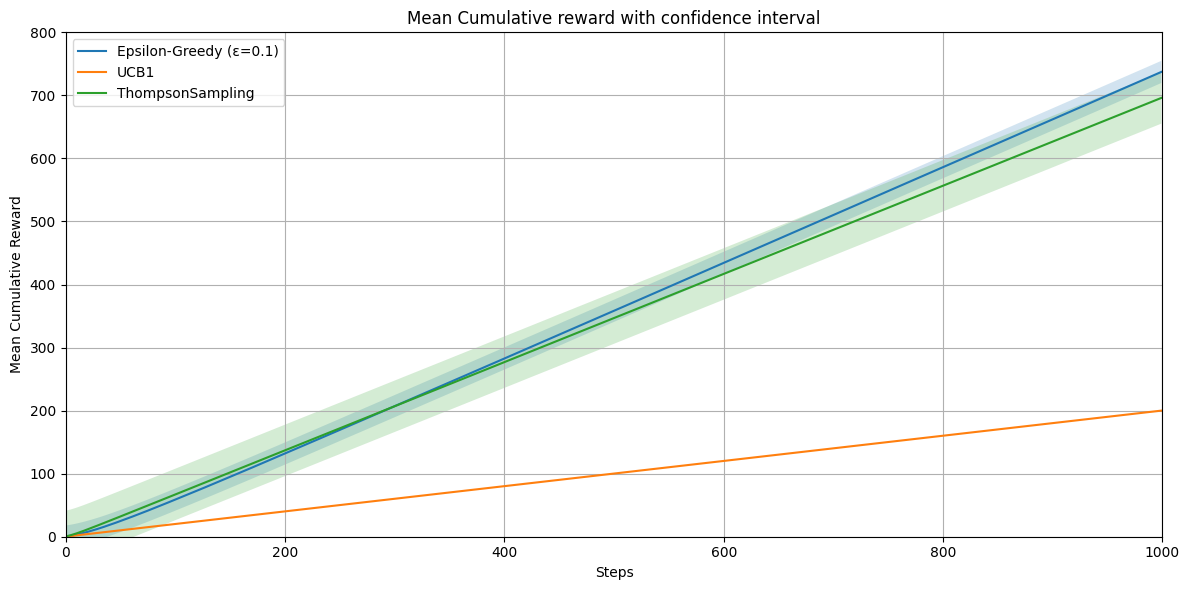

In [42]:
plot_mean_cumulative_reward_with_ci(results2, n_steps=1000, ylim_max=800)

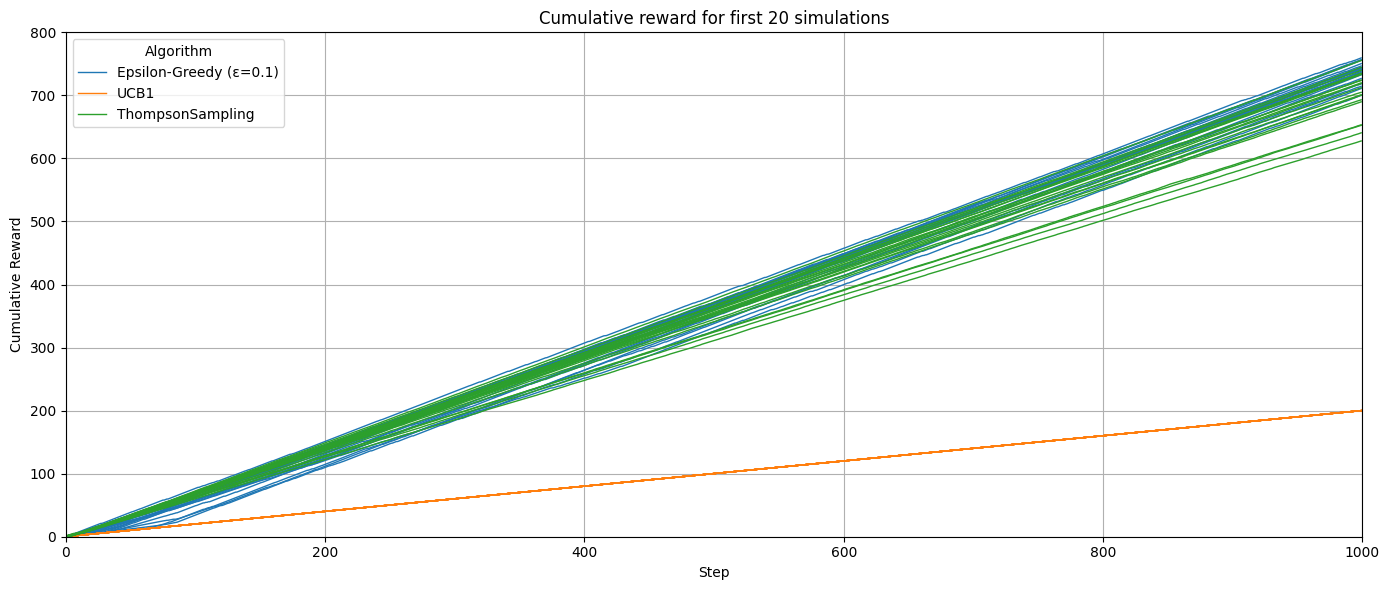

In [43]:
plot_first_n_simulations(df_all2, n_simulations=20, xlim_max=1000, ylim_max=800)

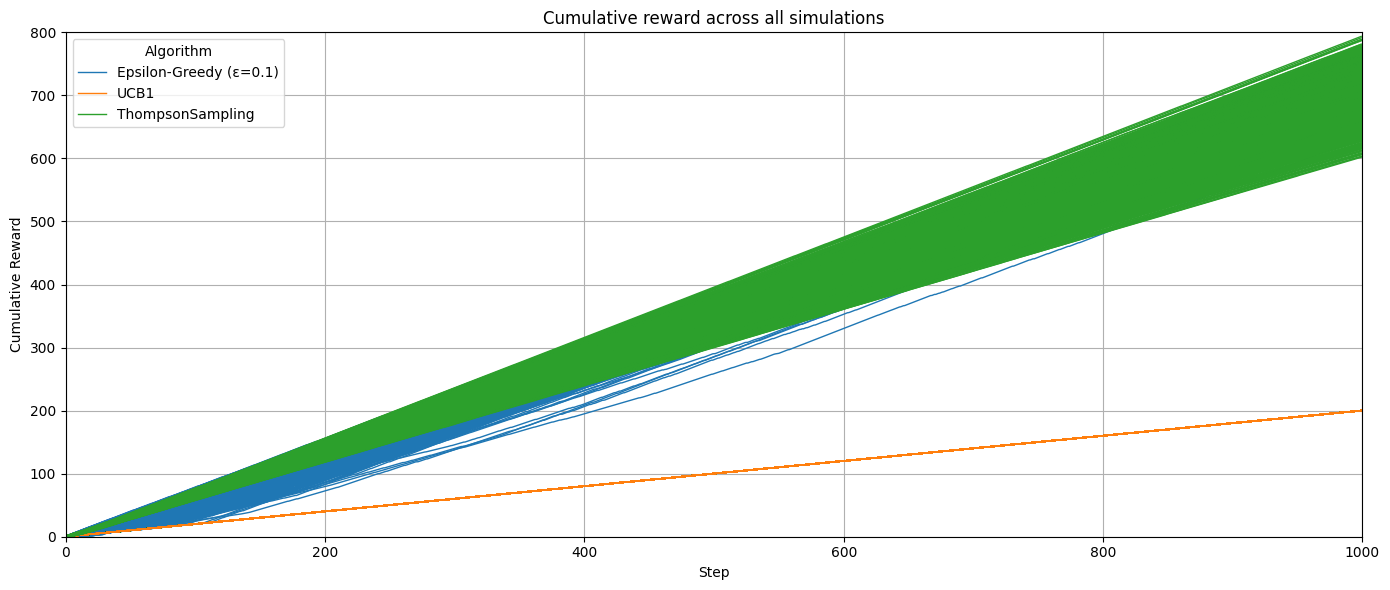

In [44]:
plot_all_simulations(df_all2, xlim_max=1000, ylim_max=800)

## Stochastic rewards (MABWiser)

In [45]:
def simulate_stochastic_mabwiser(true_rewards, n_steps, n_simulations, learning_policy, policy_name, scale=0.1):
    n_arms = len(true_rewards)
    records = []
    total_rewards = np.zeros((n_simulations, n_steps))

    for sim in range(n_simulations):
        rng_sim = np.random.default_rng(sim)

        mab = MAB(
            arms=list(range(n_arms)),
            learning_policy=learning_policy,
            seed=sim
        )
        mab.fit(decisions=[], rewards=[])

        reward_cum = 0
        for t in range(n_steps):
            arm = mab.predict()
            reward = rng_sim.normal(loc=true_rewards[arm], scale=scale)
            reward = np.clip(reward, 0, 1) 

            mab.partial_fit(decisions=[arm], rewards=[reward])
            reward_cum += reward
            total_rewards[sim, t] = reward

            records.append({
                "Simulation": sim,
                "Step": t,
                "Algorithm": policy_name,
                "Arm": arm,
                "Reward": reward,
                "Cumulative Reward": reward_cum
            })

    cumulative_rewards = np.cumsum(total_rewards, axis=1)
    mean_rewards = np.mean(cumulative_rewards, axis=0)
    std_rewards = np.std(cumulative_rewards, axis=0)
    final_mean = np.mean(cumulative_rewards[:, -1])

    return {
        "mean_rewards": mean_rewards,
        "std_rewards": std_rewards,
        "final_mean": final_mean,
        "records_df": pd.DataFrame(records)
    }

In [54]:
# Parameters
n_steps = 1000
n_simulations = 100
true_rewards = np.array([0.2, 0.5, 0.8, 0.1, 0.3, 0.4, 0.7, 0.6, 0.25, 0.05])
scale = 0.1
epsilon = 0.1

In [55]:
# Run the simulation
results4 = {}

In [56]:
results4[f"Epsilon-Greedy (ε={epsilon})"] = simulate_stochastic_mabwiser(
    true_rewards=true_rewards,
    n_steps=n_steps,
    n_simulations=n_simulations,
    learning_policy=LearningPolicy.EpsilonGreedy(epsilon=epsilon),
    policy_name=f"Epsilon-Greedy (ε={epsilon})",
    scale=scale
)

In [57]:
results4["UCB1"] = simulate_stochastic_mabwiser(
    true_rewards=true_rewards,
    n_steps=n_steps,
    n_simulations=n_simulations,
    learning_policy=LearningPolicy.UCB1(),
    policy_name="UCB1",
    scale=scale
)


In [58]:
results4["Thompson Sampling"] = simulate_stochastic_mabwiser(
    true_rewards=true_rewards,
    n_steps=n_steps,
    n_simulations=n_simulations,
    learning_policy=LearningPolicy.ThompsonSampling(binarizer=lambda arm, reward: int(reward > 0.5)),
    policy_name="Thompson Sampling",
    scale=scale
)

In [59]:
# Check the results
df_all4 = pd.concat([result["records_df"] for result in results4.values()], ignore_index=True)
# df_all.head()
df_all4

,Simulation,Step,Algorithm,Arm,Reward,Cumulative Reward
0,0,0,Epsilon-Greedy (ε=0.1),0,0.212573,0.212573
1,0,1,Epsilon-Greedy (ε=0.1),0,0.186790,0.399363
2,0,2,Epsilon-Greedy (ε=0.1),6,0.764042,1.163405
3,0,3,Epsilon-Greedy (ε=0.1),2,0.810490,1.973895
4,0,4,Epsilon-Greedy (ε=0.1),2,0.746433,2.720328
...,...,...,...,...,...,...
299995,99,995,Thompson Sampling,2,0.679134,769.790273
299996,99,996,Thompson Sampling,2,0.640826,770.431099
299997,99,997,Thompson Sampling,2,0.822526,771.253625
299998,99,998,Thompson Sampling,2,0.789450,772.043075


In [65]:
# Print the mean and std for the aproaches
for name, result in results4.items():
    print(f"{name}: Final mean = {result['final_mean']:.2f}, Std (first 3 steps) = {result['std_rewards'][:3]}")

Epsilon-Greedy (ε=0.1): Final mean = 733.94, Std (first 3 steps) = [0.11554201 0.18954957 0.29338786]
UCB1: Final mean = 200.80, Std (first 3 steps) = [0.09486577 0.13868924 0.17245902]
Thompson Sampling: Final mean = 782.48, Std (first 3 steps) = [0.28217409 0.41027514 0.51509626]


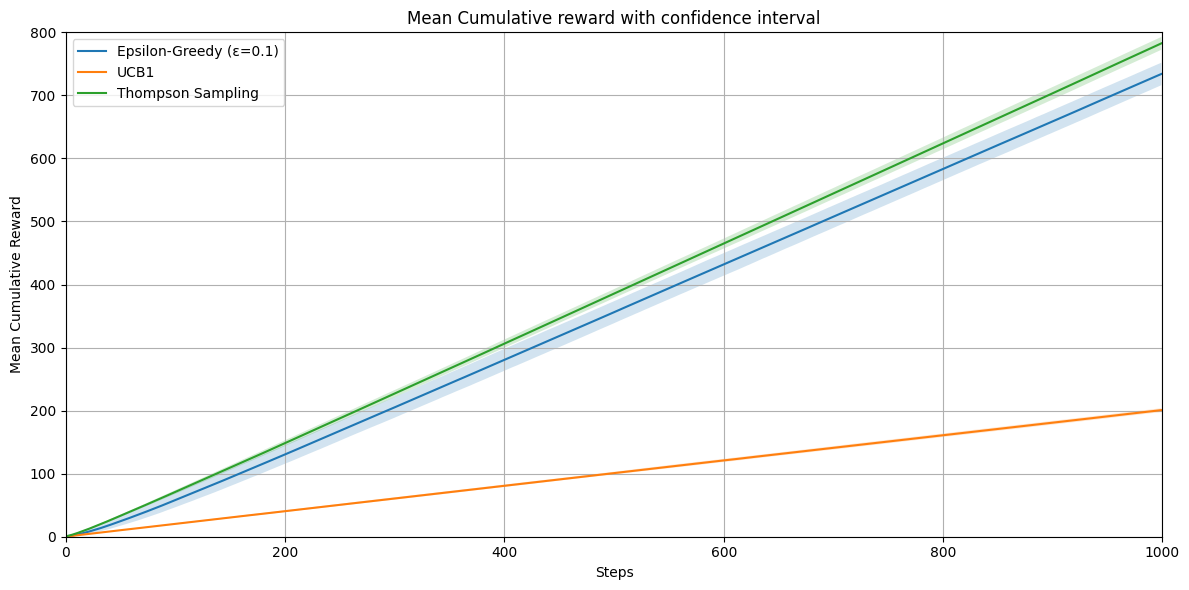

In [61]:
plot_mean_cumulative_reward_with_ci(results4, n_steps=1000, ylim_max=800)

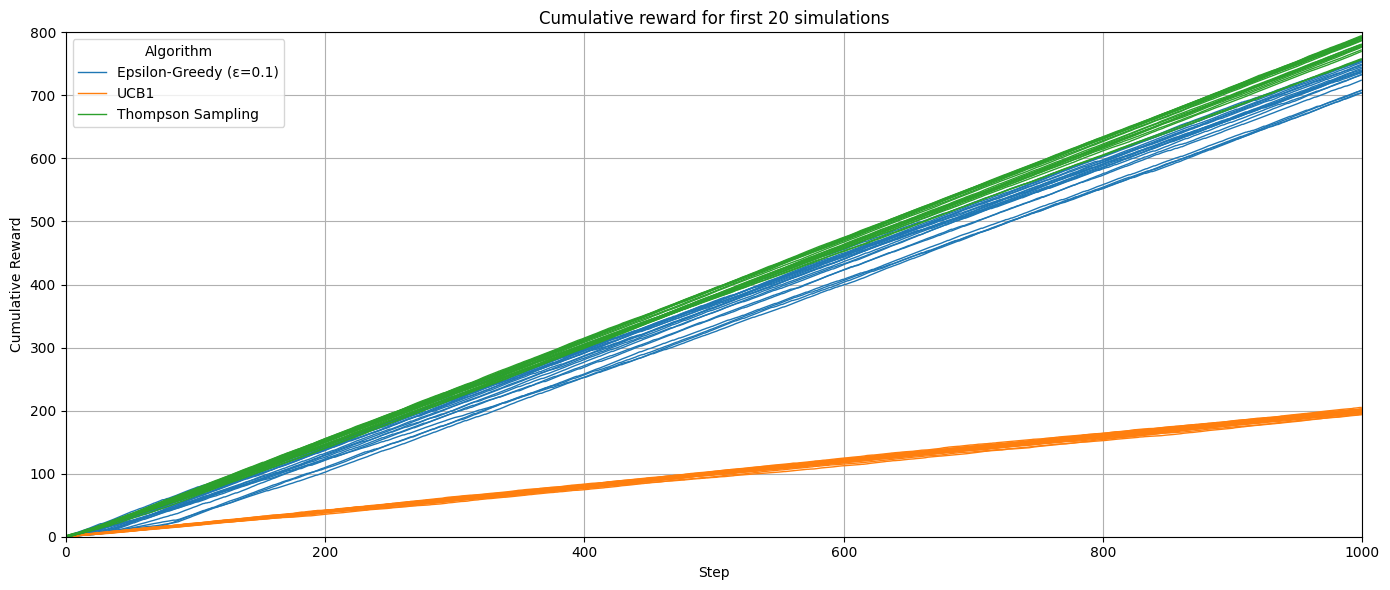

In [62]:
plot_first_n_simulations(df_all4, n_simulations=20, xlim_max=1000, ylim_max=800)

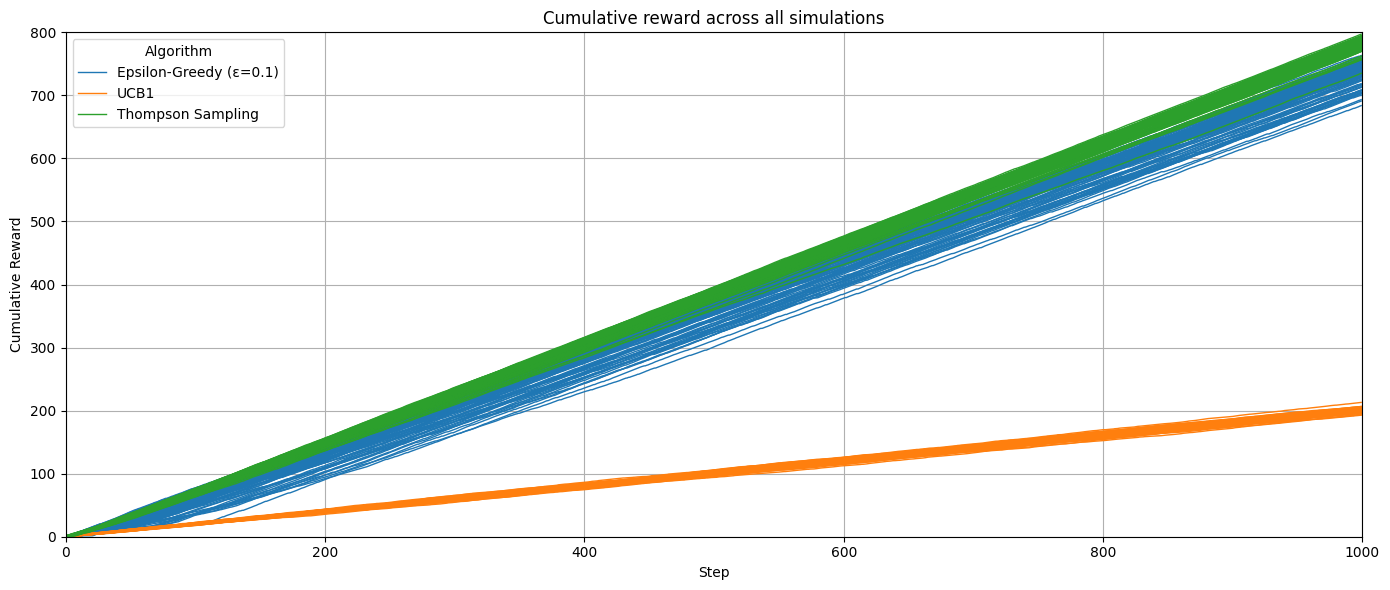

In [63]:
plot_all_simulations(df_all4, xlim_max=1000, ylim_max=800)